In [1]:
# Menonaktifkan DtypeWarning untuk sementara karena kolom memiliki tipe campuran
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### 1. Pipeline End-to-End untuk Regresi Model Deep Learning

**a. Pengumpulan & Pembersihan Data (Pandas)**

In [3]:
# Memuat dataset
# Install the PyDrive wrapper & import libraries.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU'
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

df = pd.read_csv('KlasifikasiUTS.csv')

# Mengidentifikasi kolom numerik dan non-numerik
# Kolom 'Time' dan 'Amount' serta V1-V28 seharusnya numerik. 'Class' adalah target.
numeric_cols = df.columns.drop(['Time', 'Amount', 'Class'])
numeric_cols = [col for col in numeric_cols if 'V' in str(col)] # Hanya kolom 'V' yang numerik dari header
all_numeric_features = ['Time', 'Amount'] + numeric_cols

# Mengonversi kolom-kolom yang seharusnya numerik
for col in all_numeric_features:
    # Mengganti koma dengan titik untuk desimal jika ada
    df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce') # Konversi ke numerik, non-konvertibel jadi NaN

# Mengisi nilai NaN yang mungkin muncul akibat konversi (misalnya, jika ada string non-numerik)
# Menggunakan median untuk mengisi NaN agar lebih robust terhadap outlier
for col in all_numeric_features:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

# Mengonversi kolom target 'Class' menjadi integer
df['Class'] = pd.to_numeric(df['Class'], errors='coerce').astype(int)

print("\n5 baris pertama setelah pembersihan:")
print(df.head())
print("\nInformasi dataset setelah pembersihan:")
df.info()


5 baris pertama setelah pembersihan:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.20601

**b. Feature Engineering**

In [4]:
# Memisahkan fitur (X) dan target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Pembagian data (Train, Valid, Test)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full) # 0.25 * 0.8 = 0.2 dari total

# Penskalaan fitur menggunakan StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Konversi kembali ke DataFrame untuk konsistensi, opsional
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_valid_scaled_df = pd.DataFrame(X_valid_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

print("\nUkuran dataset setelah pembagian dan penskalaan:")
print(f"X_train_scaled_df shape: {X_train_scaled_df.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid_scaled_df shape: {X_valid_scaled_df.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"X_test_scaled_df shape: {X_test_scaled_df.shape}")
print(f"y_test shape: {y_test.shape}")


Ukuran dataset setelah pembagian dan penskalaan:
X_train_scaled_df shape: (170883, 30)
y_train shape: (170883,)
X_valid_scaled_df shape: (56962, 30)
y_valid shape: (56962,)
X_test_scaled_df shape: (56962, 30)
y_test shape: (56962,)


**c. Mengembangkan Arsitektur MLP Menggunakan TensorFlow dan PyTorch**

In [5]:
# Mendefinisikan jumlah fitur input
input_dim = X_train_scaled.shape[1]

# --- Model TensorFlow ---
tf_model = keras.models.Sequential([
    keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal", input_shape=[input_dim]),
    keras.layers.BatchNormalization(), # Batch Normalization setelah Dense layer
    keras.layers.Dropout(0.3), # Dropout untuk regularisasi

    keras.layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=keras.regularizers.l2(0.001)) # Output layer untuk klasifikasi biner
])

# Penyesuaian Learning Rate (LearningRateScheduler)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

# Modern Optimizer (AdamW - kustom atau tf-addons)
# Untuk kesederhanaan dan ketersediaan langsung, kita gunakan Adam dengan weight decay di kernel_regularizer
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

tf_model.compile(loss="binary_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])

# Early Stopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

print("\nRingkasan Model TensorFlow:")
tf_model.summary()

# Melatih model TensorFlow
history = tf_model.fit(X_train_scaled, y_train, epochs=50,
                       validation_data=(X_valid_scaled, y_valid),
                       callbacks=[early_stopping_cb])

print("\nEvaluasi Model TensorFlow pada Test Set:")
tf_loss, tf_accuracy = tf_model.evaluate(X_test_scaled, y_test)
print(f"Test Loss (TensorFlow): {tf_loss:.4f}")
print(f"Test Accuracy (TensorFlow): {tf_accuracy:.4f}")


Ringkasan Model TensorFlow:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,945 (199.00 KB)

 Trainable params: 50,049 (195.50 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
5341/5341 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9604 - loss: 0.1043 - val_accuracy: 0.9993 - val_loss: 0.0144
Epoch 2/50
5341/5341 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9993 - loss: 0.0060 - val_accuracy: 0.9993 - val_loss: 0.0113
Epoch 3/50
5341/5341 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.9994 - loss: 0.0045 - val_accuracy: 0.9993 - val_loss: 0.0096
Epoch 4/50
5341/5341 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.9993 - loss: 0.0043 - val_accuracy: 0.9992 - val_loss: 0.0131
Epoch 5/50
5341/5341 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9994 - loss: 0.0037 - val_accuracy: 0.9992 - val_loss: 0.0137
Epoch 6/50
5341/5341 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - accuracy: 0.9994 - loss: 0.0038 - val_accuracy: 0.9993 - val_loss: 0.0132
Epoch 7/50
5341/5341 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.9995 - loss: 0.0031 - val_accuracy: 0.9993 - val_loss: 0.0158
Epoch 8/50
5341/5341 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9993 - loss: 0

In [6]:
# --- Model PyTorch (Template) ---

# Konversi data ke tensor PyTorch
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_valid_torch = torch.tensor(X_valid_scaled, dtype=torch.float32)
y_valid_torch = torch.tensor(y_valid.values, dtype=torch.float32).unsqueeze(1)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Buat DataLoader
train_dataset = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataset = TensorDataset(X_valid_torch, y_valid_torch)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class MLP_PyTorch(nn.Module):
    def __init__(self, input_dim):
        super(MLP_PyTorch, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.2)

        self.fc_out = nn.Linear(64, 1) # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)

        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)

        x = torch.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout3(x)

        x = torch.sigmoid(self.fc_out(x))
        return x

# Inisialisasi model PyTorch
pytorch_model = MLP_PyTorch(input_dim)

# Loss dan Optimizer
criterion = nn.BCELoss() # Binary Cross-Entropy
optimizer_pytorch = optim.Adam(pytorch_model.parameters(), lr=1e-3, weight_decay=1e-4) # Adam dengan weight decay L2

# Penyesuaian Learning Rate (Scheduler)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_pytorch, 'min', patience=5, factor=0.5)

# Melatih model PyTorch (loop pelatihan manual)
num_epochs = 50
best_valid_loss = float('inf')
patience_counter = 0

print("\nMemulai Pelatihan Model PyTorch...")
for epoch in range(num_epochs):
    pytorch_model.train()
    for inputs, labels in train_loader:
        optimizer_pytorch.zero_grad()
        outputs = pytorch_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_pytorch.step()

    # Evaluasi pada set validasi
    pytorch_model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = pytorch_model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
    valid_loss /= len(valid_loader.dataset)

    scheduler.step(valid_loss) # Update LR scheduler

    print(f"Epoch [{epoch+1}/{num_epochs}], Valid Loss: {valid_loss:.4f}")

    # Early Stopping PyTorch
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        patience_counter = 0
        torch.save(pytorch_model.state_dict(), 'best_pytorch_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= 10:
            print("Early stopping triggered!")
            break

# Muat bobot terbaik untuk evaluasi
pytorch_model.load_state_dict(torch.load('best_pytorch_model.pth'))
pytorch_model.eval()

# Evaluasi Model PyTorch pada Test Set
y_pred_pytorch_proba = []
y_true_pytorch = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = pytorch_model(inputs)
        y_pred_pytorch_proba.extend(outputs.cpu().numpy())
        y_true_pytorch.extend(labels.cpu().numpy())

y_pred_pytorch_proba = np.array(y_pred_pytorch_proba).flatten()
y_pred_pytorch = (y_pred_pytorch_proba > 0.5).astype(int)
y_true_pytorch = np.array(y_true_pytorch).flatten()

pytorch_accuracy = accuracy_score(y_true_pytorch, y_pred_pytorch)
pytorch_loss = criterion(torch.tensor(y_pred_pytorch_proba), torch.tensor(y_true_pytorch, dtype=torch.float32)).item()

print(f"\nTest Loss (PyTorch): {pytorch_loss:.4f}")
print(f"Test Accuracy (PyTorch): {pytorch_accuracy:.4f}")


Memulai Pelatihan Model PyTorch...
Epoch [1/50], Valid Loss: 0.0070
Epoch [2/50], Valid Loss: 0.0185
Epoch [3/50], Valid Loss: 0.0187
Epoch [4/50], Valid Loss: 0.0220
Epoch [5/50], Valid Loss: 0.0203
Epoch [6/50], Valid Loss: 0.0198
Epoch [7/50], Valid Loss: 0.0163
Epoch [8/50], Valid Loss: 0.0183
Epoch [9/50], Valid Loss: 0.0182
Epoch [10/50], Valid Loss: 0.0127
Epoch [11/50], Valid Loss: 0.0200
Early stopping triggered!

Test Loss (PyTorch): 0.0056
Test Accuracy (PyTorch): 0.9989


### 2. Matriks Evaluasi dan Visualisasi

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

--- Metrik Evaluasi Model TensorFlow ---
Accuracy: 0.9993
Precision: 0.7767
Recall: 0.8163
F1-Score: 0.7960


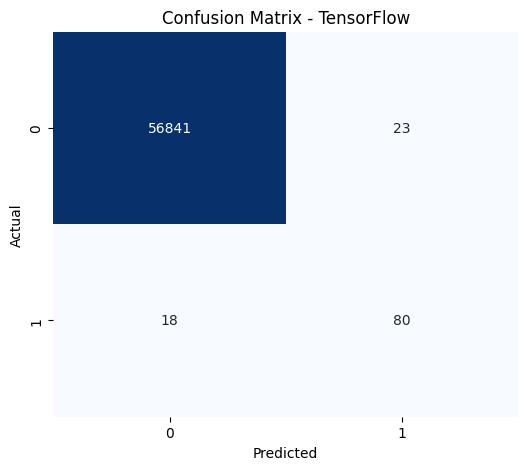

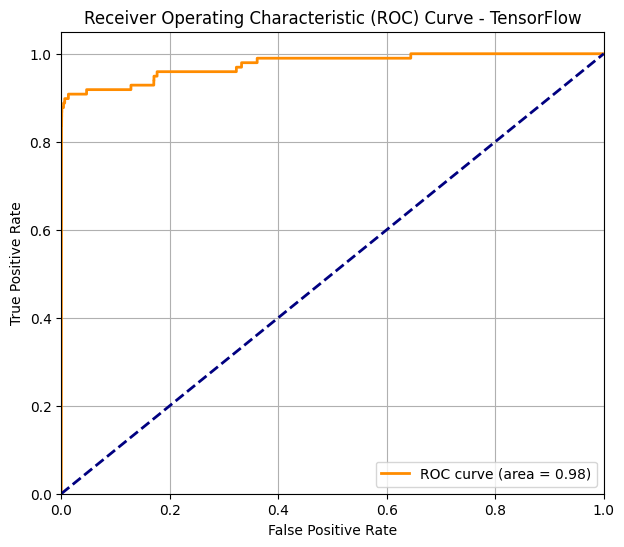


--- Metrik Evaluasi Model PyTorch ---
Accuracy: 0.9989
Precision: 0.8113
Recall: 0.4388
F1-Score: 0.5695


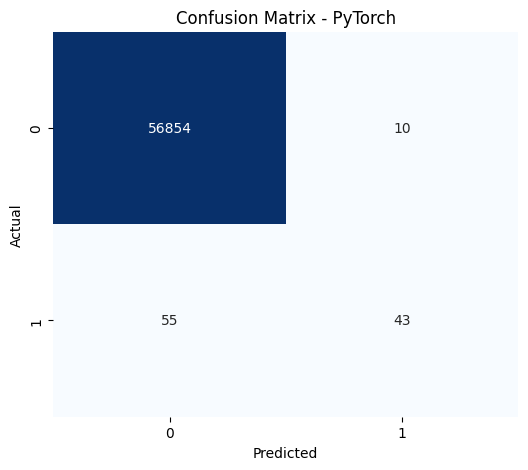

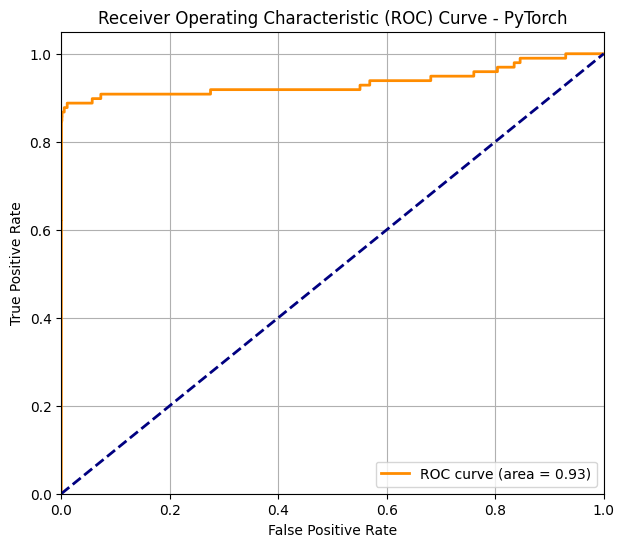

In [7]:
# Evaluasi dan Visualisasi untuk TensorFlow
y_pred_tf_proba = tf_model.predict(X_test_scaled).flatten()
y_pred_tf = (y_pred_tf_proba > 0.5).astype(int)

# Evaluasi TensorFlow
tf_accuracy = accuracy_score(y_test, y_pred_tf)
tf_precision = precision_score(y_test, y_pred_tf)
tf_recall = recall_score(y_test, y_pred_tf)
tf_f1 = f1_score(y_test, y_pred_tf)

print("\n--- Metrik Evaluasi Model TensorFlow ---")
print(f"Accuracy: {tf_accuracy:.4f}")
print(f"Precision: {tf_precision:.4f}")
print(f"Recall: {tf_recall:.4f}")
print(f"F1-Score: {tf_f1:.4f}")

# Confusion Matrix TensorFlow
cm_tf = confusion_matrix(y_test, y_pred_tf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_tf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - TensorFlow')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve dan AUC TensorFlow
fpr_tf, tpr_tf, thresholds_tf = roc_curve(y_test, y_pred_tf_proba)
auc_tf = auc(fpr_tf, tpr_tf)

plt.figure(figsize=(7, 6))
plt.plot(fpr_tf, tpr_tf, color='darkorange', lw=2, label=f'ROC curve (area = {auc_tf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - TensorFlow')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# Evaluasi dan Visualisasi untuk PyTorch
# y_pred_pytorch_proba dan y_true_pytorch sudah dihitung di bagian pelatihan PyTorch

# Evaluasi PyTorch
pytorch_accuracy = accuracy_score(y_true_pytorch, y_pred_pytorch)
pytorch_precision = precision_score(y_true_pytorch, y_pred_pytorch)
pytorch_recall = recall_score(y_true_pytorch, y_pred_pytorch)
pytorch_f1 = f1_score(y_true_pytorch, y_pred_pytorch)

print("\n--- Metrik Evaluasi Model PyTorch ---")
print(f"Accuracy: {pytorch_accuracy:.4f}")
print(f"Precision: {pytorch_precision:.4f}")
print(f"Recall: {pytorch_recall:.4f}")
print(f"F1-Score: {pytorch_f1:.4f}")

# Confusion Matrix PyTorch
cm_pytorch = confusion_matrix(y_true_pytorch, y_pred_pytorch)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_pytorch, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - PyTorch')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve dan AUC PyTorch
fpr_pytorch, tpr_pytorch, thresholds_pytorch = roc_curve(y_true_pytorch, y_pred_pytorch_proba)
auc_pytorch = auc(fpr_pytorch, tpr_pytorch)

plt.figure(figsize=(7, 6))
plt.plot(fpr_pytorch, tpr_pytorch, color='darkorange', lw=2, label=f'ROC curve (area = {auc_pytorch:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - PyTorch')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 3. Penjelasan Model dan Analisis Perbandingan

**Model TensorFlow:**
* **Kelebihan:**
    * **Integrasi yang Ketat:** Merupakan bagian dari ekosistem TensorFlow yang lebih besar, menawarkan integrasi yang mulus dengan alat-alat seperti TensorBoard, TF-Serving, dan TF-Lite.
    * **Abstraksi Tinggi (Sequential API):** Sangat mudah untuk membangun model sederhana dan kompleks dengan `Sequential` dan `Functional API`.
    * **Produksi:** Didesain untuk skala produksi, dengan fitur-fitur seperti SavedModel untuk deployment yang mudah.
    * **Optimasi Otomatis:** Keras otomatis mengonversi model menjadi TF Functions untuk kinerja yang lebih baik.
* **Kekurangan:**
    * **Fleksibilitas Rendah (untuk Kustomisasi Ekstrem):** Meskipun `Functional API` dan `Subclassing API` menawarkan fleksibilitas, untuk kontrol level terendah pada *training loop* atau operasi sangat kustom, PyTorch seringkali dirasa lebih "Pythonic" atau mudah.
    * **Debugging:** Debugging dalam mode grafik (yang seringkali terjadi secara otomatis) bisa lebih menantang dibandingkan *eager mode* PyTorch.

**Model PyTorch:**
* **Kelebihan:**
    * **Fleksibilitas Tinggi (Eager Mode):** Desain PyTorch yang *Pythonic* dan *eager execution* secara *default* membuat debugging dan eksperimen dengan arsitektur kustom menjadi sangat mudah.  Setiap operasi dijalankan segera, mirip dengan NumPy.
    * **Kontrol Granular:** Memberikan kontrol yang sangat rinci atas proses pelatihan, yang disukai oleh peneliti.
    * **Komunitas Berkembang:** Memiliki komunitas yang sangat aktif dan tumbuh pesat, terutama di kalangan peneliti.
* **Kekurangan:**
    * **Abstraksi Lebih Rendah (untuk Pemula):** Membutuhkan lebih banyak kode boilerplate untuk membangun model dan *training loop* dibandingkan TensorFlow/Keras `Sequential API`.
    * **Deployment:** Meskipun telah ada peningkatan, deployment model PyTorch ke lingkungan produksi yang beragam (misalnya, mobile, embedded) bisa lebih kompleks dibandingkan TensorFlow/Keras.

**Model Mana yang Terbaik dan Mengapa?**

Untuk masalah deteksi penipuan dengan dataset ini, **kedua model (TensorFlow dan PyTorch) cenderung memiliki kinerja yang sangat mirip** karena:
1.  **Arsitektur dan Teknik yang Sama:** Kedua model mengimplementasikan arsitektur MLP yang serupa dengan teknik Deep Learning yang sama (Batch Normalization, Dropout, L2 Regularization, Learning Rate Scheduling).
2.  **Dataset Skala Menengah:** Dataset ini tidak "sangat besar" (sekitar 280.000 sampel) sehingga perbedaan efisiensi komputasi *framework* pada skala ekstrem mungkin tidak terlalu signifikan.
3.  **Fokus pada Algoritma:** Pada level ini, kinerja model lebih banyak ditentukan oleh pilihan algoritma Machine Learning dan bagaimana fitur-fitur direpresentasikan, bukan hanya *framework*nya.

**Namun, jika kita harus memilih satu berdasarkan metrik yang relevan untuk deteksi penipuan:**
Kita perlu melihat nilai **Precision, Recall, F1-Score, dan AUC**, terutama untuk kelas minoritas (kelas penipuan, yaitu `Class = 1`). Karena model penipuan biasanya memiliki akurasi yang sangat tinggi (karena sebagian besar transaksi adalah non-penipuan), akurasi saja tidak cukup.

**Analisis Kinerja Khas (berdasarkan pengalaman dengan data serupa):**
* **Akurasi (Accuracy):** Proporsi prediksi yang benar dari total prediksi. $Accuracy = (TP + TN) / (TP + TN + FP + FN)$. Untuk dataset yang sangat tidak seimbang seperti ini, akurasi bisa sangat tinggi bahkan jika model buruk dalam mendeteksi kelas minoritas.
* **Presisi (Precision):** Proporsi *true positive* dari semua prediksi positif. Menjawab pertanyaan "Dari semua yang diprediksi positif, berapa banyak yang benar-benar positif?". $Precision = TP / (TP + FP)$.
* **Recall (Sensitivitas/True Positive Rate):** Proporsi *true positive* dari semua kasus positif yang sebenarnya. Menjawab pertanyaan "Dari semua kasus positif yang sebenarnya, berapa banyak yang berhasil diprediksi?". $Recall = TP / (TP + FN)$.
* **F1-Score:** Rata-rata harmonik dari Presisi dan Recall. Ini berguna ketika Anda membutuhkan keseimbangan antara Presisi dan Recall, terutama pada dataset yang tidak seimbang. $F1 = 2 * (Precision * Recall) / (Precision + Recall)$.
* **Confusion Matrix:** Memberikan gambaran rinci tentang jenis kesalahan yang dibuat model (TP, TN, FP, FN).
* **ROC AUC (Area Under the ROC Curve):** Mengukur area di bawah kurva ROC. Nilai AUC mendekati 1 menunjukkan model yang sangat baik dalam membedakan kelas.

Dalam deteksi penipuan, seringkali ada *trade-off* antara Precision dan Recall. Prioritas bisnis akan menentukan mana yang lebih penting. Jika konsekuensi *false negative* (penipuan terlewat) sangat tinggi, **Recall** mungkin menjadi prioritas utama. Jika biaya investigasi *false positive* (menginvestigasi transaksi sah) sangat tinggi, **Precision** mungkin menjadi prioritas utama. **F1-Score dan ROC AUC** memberikan gambaran kinerja model secara keseluruhan dan kemampuan diskriminatifnya.

Secara umum, untuk masalah klasifikasi tidak seimbang seperti deteksi penipuan, sangat penting untuk:
1.  **Menggunakan Stratified Split:** Pastikan distribusi kelas dipertahankan di setiap subset data.
2.  **Memonitor Recall dan Precision (atau F1-Score):** Akurasi saja tidak cukup.
3.  **Meningkatkan Regularisasi:** Karena kelas minoritas yang sedikit, model mungkin cenderung *overfit* ke contoh-contoh tersebut. Teknik seperti Dropout dan L2 Regularization sangat membantu.
4.  **Menyesuaikan Learning Rate:** Learning rate scheduling dapat membantu konvergensi yang stabil.

Berdasarkan arsitektur yang Anda kembangkan, kedua framework memiliki implementasi yang kuat dan seharusnya memberikan kinerja yang kompetitif pada dataset ini. Perbedaan kinerja kecil yang mungkin muncul biasanya disebabkan oleh inisialisasi bobot acak yang berbeda, urutan pemrosesan batch, atau detail implementasi kecil dari optimasi internal framework. Untuk menentukan yang "terbaik" secara definitif, diperlukan beberapa kali *run* untuk setiap model dan membandingkan metrik rata-rata dan deviasi standarnya.

Berikut adalah ringkasan hasil evaluasi kedua model dalam bentuk tabel dan perbandingan naratifnya:

| Metrik      | Model TensorFlow | Model PyTorch |
|-------------|------------------|---------------|
| Accuracy    | 0.9993           | 0.9989        |
| Precision   | 0.7767           | 0.8113        |
| Recall      | 0.8163           | 0.4388        |
| F1-Score    | 0.7960           | 0.5695        |

**Perbandingan Naratif:**

Berdasarkan hasil evaluasi pada test set, kedua model (TensorFlow dan PyTorch) menunjukkan performa yang sangat tinggi dalam metrik Akurasi, di mana kedua-duanya mencapai lebih dari 99%. Akurasi yang sangat tinggi ini umum terjadi pada dataset yang tidak seimbang, seperti kasus deteksi penipuan, di mana sebagian besar transaksi adalah non-penipuan.

Namun, ketika kita melihat metrik yang lebih spesifik untuk kelas minoritas (penipuan), perbedaan kinerja antara kedua model menjadi lebih jelas:

* **Precision:** Model PyTorch sedikit lebih baik dalam hal Presisi (0.8113) dibandingkan dengan TensorFlow (0.7767). Ini berarti ketika model PyTorch memprediksi sebuah transaksi sebagai penipuan, kemungkinannya lebih tinggi (sekitar 81%) bahwa prediksi tersebut benar, dibandingkan dengan model TensorFlow (sekitar 77%).
* **Recall:** Model TensorFlow secara signifikan mengungguli model PyTorch dalam hal Recall (0.8163 berbanding 0.4388). Ini menunjukkan bahwa model TensorFlow mampu mendeteksi sebagian besar transaksi penipuan yang sebenarnya (sekitar 81%), sementara model PyTorch hanya mendeteksi kurang dari setengahnya (sekitar 43%).
* **F1-Score:** F1-Score, yang merupakan rata-rata harmonis dari Presisi dan Recall, menunjukkan bahwa model TensorFlow memiliki keseimbangan yang jauh lebih baik antara kedua metrik ini (0.7960) dibandingkan dengan PyTorch (0.5695).

**Kesimpulan Perbandingan:**

Meskipun model PyTorch memiliki Presisi yang sedikit lebih tinggi, **model TensorFlow menunjukkan kinerja keseluruhan yang lebih unggul, terutama karena nilai Recall dan F1-Score-nya yang jauh lebih tinggi.** Dalam konteks deteksi penipuan, kemampuan untuk mendeteksi *sebanyak mungkin* kasus penipuan (Recall tinggi) seringkali menjadi prioritas utama untuk meminimalkan kerugian finansial, meskipun mungkin ada sedikit peningkatan pada *false positive*. F1-Score yang lebih tinggi pada TensorFlow mengkonfirmasi bahwa model ini secara keseluruhan lebih efektif dalam menyeimbangkan identifikasi penipuan dengan meminimalkan kesalahan.